# Parameter sweep for LBI predictor

Load flu tip attributes and final clade frequencies and then calculate the error of an exponential growth model based on just the LBI predictor across a range of predictor coefficients. The goal is to determine the shape of the error function that is exposed to scipy's optimization machinery.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

plt.style.use("huddlej")

In [2]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [3]:
sys.path.insert(0, "../src")

In [4]:
from fit_model import DistanceExponentialGrowthModel, sum_of_differences
from weighted_distances import get_distances_by_sample_names

## Load data

Define the range of possible coefficient values to explore.

In [5]:
coefficients = np.linspace(-15, 15, 31)

In [6]:
delta_time = 1.0
l1_lambda = 0.0

In [7]:
last_timepoint = pd.to_datetime("2014-10-01")

In [8]:
distances = pd.read_csv(
    "../results/builds/h3n2/10_viruses_per_month/sample_0/1994-10-01--2015-10-01/target_distances.tsv",
    sep="\t"
)

In [9]:
distances_by_sample = get_distances_by_sample_names(distances)

In [10]:
# Load tip attributes.
X = pd.read_csv(
    "../results/builds/h3n2/10_viruses_per_month/sample_0/1994-10-01--2015-10-01/tip_attributes_with_weighted_distances.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [11]:
X.columns

Index(['strain', 'aa_sequence', 'branch_length', 'cTiter', 'cTiterSub',
       'cTiterSub_star', 'cTiterSub_x', 'clade_membership', 'clock_length',
       'country', 'country_entropy', 'dTiter', 'dTiterSub', 'date',
       'delta_frequency', 'dms', 'dms_star', 'ep', 'ep_kratsch_x',
       'ep_luksza_x', 'ep_star', 'ep_x', 'lbi', 'mutation_length', 'ne',
       'ne_star', 'numdate', 'raw_date', 'rb', 'region', 'region_entropy',
       'is_terminal', 'timepoint', 'lineage', 'segment', 'frequency', 'naive',
       'weighted_distance_to_future', 'weighted_distance_to_present',
       'log2_distance_effect'],
      dtype='object')

In [12]:
X = X.loc[:, ["strain", "clade_membership", "timepoint", "cTiterSub_x", "lbi", "ep", "ep_x", "ne", "delta_frequency", "frequency",
              "weighted_distance_to_present", "weighted_distance_to_future"]].copy()

In [13]:
X.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency,weighted_distance_to_present,weighted_distance_to_future
0,A/Geneva/A9509/1995,35491c6,1995-10-01,-0.0,0.428328,9,-0.0,1,0.967894,0.004688,8.067983,13.840217
1,A/HongKong/49/1995,35491c6,1995-10-01,-0.0,0.401610,8,-0.0,0,0.967894,0.153221,6.221413,10.089619
2,A/Malaysia/7145/1995,35491c6,1995-10-01,-0.0,0.420684,11,-0.0,2,0.967894,0.182468,7.812880,14.282611
3,A/Malaysia/7831/1995,35491c6,1995-10-01,-0.0,0.389375,10,-0.0,1,0.967894,0.100902,8.626524,6.363209
4,A/Malaysia/7832/1995,35491c6,1995-10-01,-0.0,0.345868,13,-0.0,3,0.967894,0.100902,10.370533,16.322163


In [14]:
X.shape

(4498, 12)

In [15]:
X = X[~pd.isnull(X["weighted_distance_to_present"])].copy()

In [16]:
X.shape

(3946, 12)

In [17]:
X["y"] = X["weighted_distance_to_future"]

In [18]:
y = X.loc[:, ["strain", "timepoint", "y", "frequency", "weighted_distance_to_future"]].copy()

In [19]:
y["timepoint"] = y["timepoint"] - pd.DateOffset(months=12)

In [20]:
X.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency,weighted_distance_to_present,weighted_distance_to_future,y
0,A/Geneva/A9509/1995,35491c6,1995-10-01,-0.0,0.428328,9,-0.0,1,0.967894,0.004688,8.067983,13.840217,13.840217
1,A/HongKong/49/1995,35491c6,1995-10-01,-0.0,0.401610,8,-0.0,0,0.967894,0.153221,6.221413,10.089619,10.089619
2,A/Malaysia/7145/1995,35491c6,1995-10-01,-0.0,0.420684,11,-0.0,2,0.967894,0.182468,7.812880,14.282611,14.282611
3,A/Malaysia/7831/1995,35491c6,1995-10-01,-0.0,0.389375,10,-0.0,1,0.967894,0.100902,8.626524,6.363209,6.363209
4,A/Malaysia/7832/1995,35491c6,1995-10-01,-0.0,0.345868,13,-0.0,3,0.967894,0.100902,10.370533,16.322163,16.322163


In [21]:
y.head()

,strain,timepoint,y,frequency,weighted_distance_to_future
0,A/Geneva/A9509/1995,1994-10-01,13.840217,0.004688,13.840217
1,A/HongKong/49/1995,1994-10-01,10.089619,0.153221,10.089619
2,A/Malaysia/7145/1995,1994-10-01,14.282611,0.182468,14.282611
3,A/Malaysia/7831/1995,1994-10-01,6.363209,0.100902,6.363209
4,A/Malaysia/7832/1995,1994-10-01,16.322163,0.100902,16.322163


In [22]:
X = X[X["timepoint"] <= last_timepoint - pd.DateOffset(months=12)]

In [23]:
X.tail()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency,weighted_distance_to_present,weighted_distance_to_future,y
3428,A/Yokohama/164/2012,a229f16,2013-10-01,-9.715181,0.103880,37,-5.913805,11,-0.445160,0.000008,3.344471,6.243679,6.243679
3429,A/Yucatan/88/2013,1a16e36,2013-10-01,-9.450625,0.219904,37,-5.186669,11,0.320612,0.008169,2.973871,5.158547,5.158547
3430,A/Yucatan/94/2013,1a16e36,2013-10-01,-9.450625,0.217509,37,-5.186669,14,0.320612,0.008176,5.924827,8.158523,8.158523
3431,A/Zambia/13/109/2013,66a66dd,2013-10-01,-9.450625,0.195397,37,-5.186669,11,0.004446,0.005162,2.973871,5.158547,5.158547
3432,A/Zambia/13/127/2013,66a66dd,2013-10-01,-9.450625,0.174756,37,-4.837141,12,0.004446,0.007805,4.928399,7.054765,7.054765


## Inspect LBI model

Text(0,0.5,'Weighted distance')

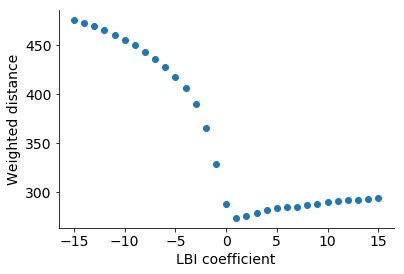

In [29]:
predictors = ["lbi"]
l1_lambda = 0.5

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("Weighted distance")

In [30]:
y.head()

,strain,timepoint,y,frequency,weighted_distance_to_future
0,A/Geneva/A9509/1995,1994-10-01,13.840217,0.004688,13.840217
1,A/HongKong/49/1995,1994-10-01,10.089619,0.153221,10.089619
2,A/Malaysia/7145/1995,1994-10-01,14.282611,0.182468,14.282611
3,A/Malaysia/7831/1995,1994-10-01,6.363209,0.100902,6.363209
4,A/Malaysia/7832/1995,1994-10-01,16.322163,0.100902,16.322163


In [27]:
min(errors)

273.18885045051576

In [28]:
coefficients[np.argmin(errors)]

1.0

## Inspect cTiterSub model

Text(0,0.5,'Weighted distance')

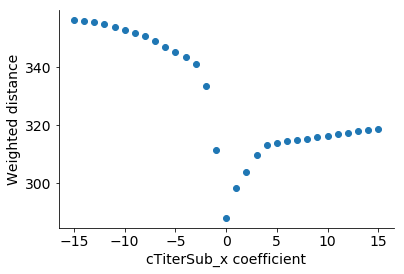

In [38]:
predictors = ["cTiterSub_x"]
l1_lambda = 0.5

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("cTiterSub_x coefficient")
plt.ylabel("Weighted distance")

In [39]:
min(errors)

287.91136622428894

In [40]:
coefficients[np.argmin(errors)]

0.0

## Inspect epitope count model

Text(0,0.5,'Weighted distance')

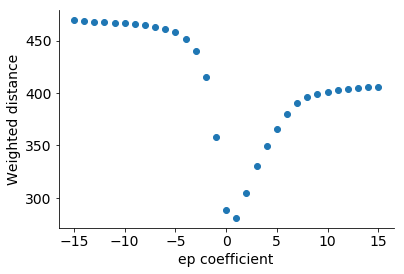

In [35]:
predictors = ["ep"]
l1_lambda = 0.5

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("ep coefficient")
plt.ylabel("Weighted distance")

In [36]:
min(errors)

280.77797079086304

In [37]:
coefficients[np.argmin(errors)]

1.0

## Inspect epitope cross-immunity model

In [ ]:
predictors = ["ep_x"]

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("Weighted distance")

In [ ]:
min(errors)

In [ ]:
coefficients[np.argmin(errors)]

## Inspect delta frequency model

Text(0,0.5,'Weighted distance')

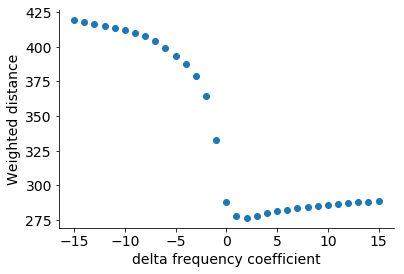

In [41]:
predictors = ["delta_frequency"]
l1_lambda = 0.5

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)
model.mean_stds_ = model.calculate_mean_stds(X, model.predictors)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("delta frequency coefficient")
plt.ylabel("Weighted distance")

In [42]:
min(errors)

276.448011636734

In [43]:
coefficients[np.argmin(errors)]

2.0

## Inspect two-parameter models

In [ ]:
predictors = ["lbi", "cTiterSub_x"]

model = DistanceExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_differences,
    distances=distances_by_sample
)

In [ ]:
len(coefficients)

In [ ]:
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("Weighted distance")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [ ]:
predictors = ["lbi", "cTiterSub_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "cTiterSub": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

In [ ]:
records_df = pd.DataFrame(records)
records_df.sort_values("error").head()

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("MAE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)